In [76]:
import os
import subprocess
import pandas as pd
import time
import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7, 8.27)})

In [77]:
def run_experiment(exp_name: str, rps=100, duration_sec=5) -> str:
    dump_file = f'/tmp/{exp_name}.bin'
    out_csv = f'/tmp/{exp_name}.csv'

    run_vegeta = f"""
        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate {rps} -duration {duration_sec}s -timeout 1s -name {exp_name} -workers 1 > {dump_file}
    """
    #show_plot = f"cat {dump_file} | vegeta report -reporter plot > /tmp/plot.html; open /tmp/plot.html"    
    print(subprocess.run(run_vegeta, shell=True))
    print('---'*10)
    print_report = f"cat {dump_file} | vegeta report -reporter text > /tmp/res.txt"
    subprocess.run(print_report, shell=True)
    print(open('/tmp/res.txt').read())

def read_experiment(csv_path: str, warmup_time_sec = 0.2) -> pd.DataFrame:
    names = ['unix_ts_ns', 'http_code', 'latency_ns', 'bytes_out', 'bytes_in', 'x', 'error', 'exp_name', 'y']
    data = pd.read_csv(csv_path, header=None, names=names)
    del data['error']
    del data['x']
    del data['y']
    del data['bytes_out']
    del data['bytes_in']
    begin_ts_ns = data.unix_ts_ns.min()
    exp_start_ts_ns = begin_ts_ns + int(warmup_time_sec * 1_000_000_000)
    data = data[data.unix_ts_ns > exp_start_ts_ns]
    data.reset_index(drop=True, inplace=True)
    data['latency_ms'] = (data['latency_ns'] / 1_000_000).round(2)
    del data['unix_ts_ns']
    del data['latency_ns']
    return data

def aggr_exp(exp_names: list) -> str:
    out_csv = f'/tmp/out.csv'
    dump_files = ','.join([f'/tmp/{exp_name}.bin' for exp_name in exp_names])
    dump_ext = f"vegeta dump -inputs {dump_files} -output {out_csv} -dumper csv"
    print(subprocess.run(dump_ext, shell=True))
    return out_csv

def plot_exp_data(exp_data):
    ax = sns.boxplot(x='latency_ms', y='exp_name', data=exp_data)

In [150]:
def latency_table(exp_data):
    a = exp_data.groupby('exp_name').quantile([.95, .98, .99])
    a = a.reset_index().pivot(index='exp_name', columns='level_1', values='latency_ms')
    a = a.round(1)
    df = a.reset_index()
    df['exp_name'], df['rps'] = df.exp_name.str.split('_rps_').str
    df['rps'] = df['rps'].astype(int)
    df.sort_values('rps', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = df[['rps','exp_name', 0.95, 0.98, 0.99]]
    return df.set_index('rps', drop=True)

In [78]:
exp_name = 'aiohttp_sleep_50_rps_100'
run_experiment(exp_name)

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 100 -duration 5s -timeout 1s -name aiohttp_sleep_50_rps_100 -workers 1 > /tmp/aiohttp_sleep_50_rps_100.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            500, 100.20
Duration      [total, attack, wait]    5.042442525s, 4.989956764s, 52.485761ms
Latencies     [mean, 50, 95, 99, max]  51.569273ms, 51.469544ms, 52.599499ms, 53.386448ms, 55.376723ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:500  
Error Set:



CompletedProcess(args='vegeta dump -inputs /tmp/aiohttp_sleep_50_rps_100.bin -output /tmp/out.csv -dumper csv', returncode=0)


,http_code,exp_name,latency_ms
0,200,aiohttp_sleep_50_rps_100,50.98
1,200,aiohttp_sleep_50_rps_100,51.30
2,200,aiohttp_sleep_50_rps_100,51.14
3,200,aiohttp_sleep_50_rps_100,50.80
4,200,aiohttp_sleep_50_rps_100,51.54


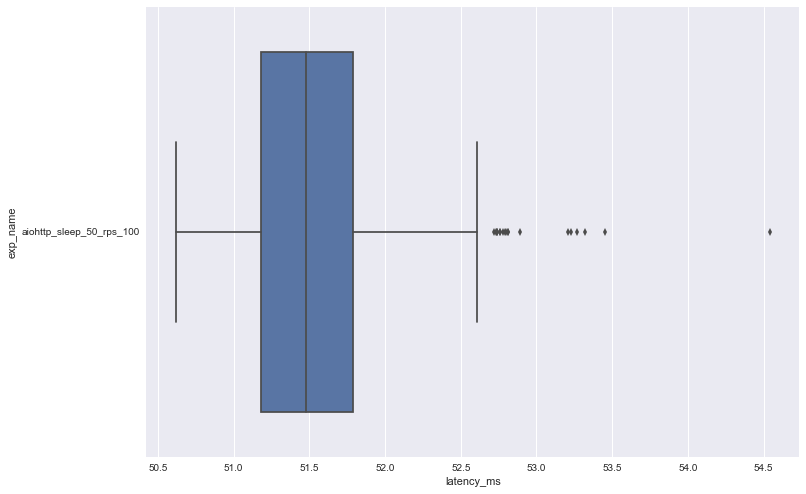

In [79]:
csv_file = aggr_exp([exp_name])
exp_data = read_experiment(csv_file, warmup_time_sec=1)
plot_exp_data(exp_data)
exp_data.head()

In [161]:
exp_names = []

In [162]:
rps_list = [750, 1000, 1250]

In [172]:
rps_list

[750, 1000, 1250]

In [163]:
from multiprocessing import Process

def run_aiohttp():
    subprocess.run('./aiohttp_server.py', shell=True)

In [170]:
p = Process(target=run_aiohttp)
p.start()

p.is_alive()
p.terminate()

True

# Asyncio 50ms

In [181]:
def benchmark(start_server, exp_name: str, rps_list: list, exp_names: list):
    
    exp_name_ = exp_name
    p = Process(target=run_aiohttp)
    p.start()
    time.sleep(0.2)
    new_exp_names = []
    for rps in rps_list:
        exp_name = f'{exp_name_}_rps_{rps}'
        exp_names.append(exp_name)
        new_exp_names.append(exp_name)
        run_experiment(exp_name, rps=rps)
        time.sleep(1)

    p.terminate()
    time.sleep(0.2)

In [ ]:
benchmark(run_aiohttp, 'aiohttp_sleep_50', rps_list, exp_names)

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 750 -duration 5s -timeout 1s -name aiohttp_sleep_50_rps_750 -workers 1 > /tmp/aiohttp_sleep_50_rps_750.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            3750, 750.03
Duration      [total, attack, wait]    5.050754353s, 4.99982828s, 50.926073ms
Latencies     [mean, 50, 95, 99, max]  51.602972ms, 51.04313ms, 51.468167ms, 80.061867ms, 122.374932ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:3750  
Error Set:



In [87]:
p = Process(target=run_aiohttp)
p.start()
time.sleep(0.2)

for rps in rps_list:
    exp_name = f'aiohttp_sleep_50_rps_{rps}'
    exp_names.append(exp_name)
    run_experiment(exp_name, rps=rps)
    time.sleep(1)
    
p.terminate()
time.sleep(0.2)


CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 100 -duration 5s -timeout 1s -name aiohttp_sleep_50_rps_100 -workers 1 > /tmp/aiohttp_sleep_50_rps_100.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            500, 100.19
Duration      [total, attack, wait]    5.042412459s, 4.990590191s, 51.822268ms
Latencies     [mean, 50, 95, 99, max]  51.503584ms, 51.388425ms, 52.484992ms, 53.183655ms, 55.246466ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:500  
Error Set:

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 250 -duration 5s -timeout 1s -name aiohttp_sleep_50_rps_250 -workers 1 > /tmp/aiohttp_sleep_50_rps_250.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]          

# Asyncio uvloop 50ms

In [88]:
rps_list = [100, 250, 500, 750,]
for rps in rps_list:
    exp_name = f'aiohttp_uvloop_sleep_50_rps_{rps}'
    exp_names.append(exp_name)
    run_experiment(exp_name, rps=rps)
    time.sleep(1)

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 100 -duration 5s -timeout 1s -name aiohttp_uvloop_sleep_50_rps_100 -workers 1 > /tmp/aiohttp_uvloop_sleep_50_rps_100.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            500, 100.16
Duration      [total, attack, wait]    5.045209514s, 4.991767547s, 53.441967ms
Latencies     [mean, 50, 95, 99, max]  51.50039ms, 51.480431ms, 52.645459ms, 53.387216ms, 56.96316ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:500  
Error Set:

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 250 -duration 5s -timeout 1s -name aiohttp_uvloop_sleep_50_rps_250 -workers 1 > /tmp/aiohttp_uvloop_sleep_50_rps_250.bin\n    ", returncode=0)
------------------------------
Requests   

# Tornado

In [144]:
rps_list = [100, 250, 500, 750,]
for rps in rps_list:
    exp_name = f'tornado_sleep_50_rps_{rps}'
    exp_names.append(exp_name)
    run_experiment(exp_name, rps=rps)
    time.sleep(1)

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 100 -duration 5s -timeout 1s -name tornado_sleep_50_rps_100 -workers 1 > /tmp/tornado_sleep_50_rps_100.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            500, 100.16
Duration      [total, attack, wait]    5.04506166s, 4.992030391s, 53.031269ms
Latencies     [mean, 50, 95, 99, max]  52.268297ms, 52.186308ms, 53.153513ms, 54.370849ms, 56.533153ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:500  
Error Set:

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 250 -duration 5s -timeout 1s -name tornado_sleep_50_rps_250 -workers 1 > /tmp/tornado_sleep_50_rps_250.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]           

# Tornado uvloop

In [152]:
rps_list = [100, 250, 500, 750,]
for rps in rps_list:
    exp_name = f'tornado_uvloop_sleep_50_rps_{rps}'
    exp_names.append(exp_name)
    run_experiment(exp_name, rps=rps)
    time.sleep(1)

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 100 -duration 5s -timeout 1s -name tornado_uvloop_sleep_50_rps_100 -workers 1 > /tmp/tornado_uvloop_sleep_50_rps_100.bin\n    ", returncode=0)
------------------------------
Requests      [total, rate]            500, 100.19
Duration      [total, attack, wait]    5.043127319s, 4.990482096s, 52.645223ms
Latencies     [mean, 50, 95, 99, max]  51.343196ms, 51.333996ms, 52.361073ms, 52.744597ms, 54.200573ms
Bytes In      [total, mean]            0, 0.00
Bytes Out     [total, mean]            0, 0.00
Success       [ratio]                  100.00%
Status Codes  [code:count]             200:500  
Error Set:

CompletedProcess(args="\n        echo 'GET http://localhost:8890/sleep50' | vegeta -cpus 1 attack -rate 250 -duration 5s -timeout 1s -name tornado_uvloop_sleep_50_rps_250 -workers 1 > /tmp/tornado_uvloop_sleep_50_rps_250.bin\n    ", returncode=0)
------------------------------
Requests 

In [153]:
exp_names

['aiohttp_sleep_50_rps_100',
 'aiohttp_sleep_50_rps_250',
 'aiohttp_sleep_50_rps_500',
 'aiohttp_sleep_50_rps_750',
 'aiohttp_uvloop_sleep_50_rps_100',
 'aiohttp_uvloop_sleep_50_rps_250',
 'aiohttp_uvloop_sleep_50_rps_500',
 'aiohttp_uvloop_sleep_50_rps_750',
 'tornado_sleep_50_rps_100',
 'tornado_sleep_50_rps_250',
 'tornado_sleep_50_rps_500',
 'tornado_sleep_50_rps_750',
 'tornado_uvloop_sleep_50_rps_100',
 'tornado_uvloop_sleep_50_rps_250',
 'tornado_uvloop_sleep_50_rps_500',
 'tornado_uvloop_sleep_50_rps_750']

In [154]:
csv_file = aggr_exp(exp_names)
exp_data = read_experiment(csv_file, warmup_time_sec=1)
# plot_exp_data(exp_data)
exp_data.head()

CompletedProcess(args='vegeta dump -inputs /tmp/aiohttp_sleep_50_rps_100.bin,/tmp/aiohttp_sleep_50_rps_250.bin,/tmp/aiohttp_sleep_50_rps_500.bin,/tmp/aiohttp_sleep_50_rps_750.bin,/tmp/aiohttp_uvloop_sleep_50_rps_100.bin,/tmp/aiohttp_uvloop_sleep_50_rps_250.bin,/tmp/aiohttp_uvloop_sleep_50_rps_500.bin,/tmp/aiohttp_uvloop_sleep_50_rps_750.bin,/tmp/tornado_sleep_50_rps_100.bin,/tmp/tornado_sleep_50_rps_250.bin,/tmp/tornado_sleep_50_rps_500.bin,/tmp/tornado_sleep_50_rps_750.bin,/tmp/tornado_uvloop_sleep_50_rps_100.bin,/tmp/tornado_uvloop_sleep_50_rps_250.bin,/tmp/tornado_uvloop_sleep_50_rps_500.bin,/tmp/tornado_uvloop_sleep_50_rps_750.bin -output /tmp/out.csv -dumper csv', returncode=0)


,http_code,exp_name,latency_ms
0,200,aiohttp_sleep_50_rps_250,54.25
1,200,aiohttp_sleep_50_rps_500,89.43
2,200,aiohttp_sleep_50_rps_750,114.71
3,200,aiohttp_uvloop_sleep_50_rps_100,56.96
4,200,aiohttp_uvloop_sleep_50_rps_250,53.45


In [157]:
df = latency_table(exp_data)

In [160]:
df

level_1,exp_name,0.95,0.98,0.99
rps,,,,
100,aiohttp_sleep_50,52.4,52.9,53.1
100,aiohttp_uvloop_sleep_50,52.6,53.0,53.3
100,tornado_sleep_50,53.1,53.6,54.4
100,tornado_uvloop_sleep_50,52.4,52.6,52.7
250,aiohttp_sleep_50,52.0,52.2,52.8
250,aiohttp_uvloop_sleep_50,52.5,52.7,52.8
250,tornado_sleep_50,53.1,53.4,53.6
250,tornado_uvloop_sleep_50,51.9,52.3,52.6
500,aiohttp_sleep_50,51.4,51.9,55.0
